In [1]:
# Importing relevant libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from geopy.distance import distance
from datetime import datetime

In [2]:
working_directory = "C:\Projects\AkzoNobel interview presentation\data"
os.chdir(working_directory) # setting up the working directory

In [3]:
raw_data = pd.read_excel("VLCC Data Extract.xlsx") # importing the dataset

In [4]:
raw_data.head(3) # returning top 5 rows to check whether the impoert was succesful or not

,Datetime,Speed Through Water [kts],Shaft Power [kW],Fuel Oil Cons. [kg/hour],Shaft Speed [RPM],Torque [nM],Wind Speed Abs. [kts],Speed Over Ground [kts],Draft Aft [m],Draft Fore [m],Latitude,Longitude
0,2018-07-19 00:00:00,10.700000,6489.000000,1131.000000,41.900000,1479.000000,11.600000,11.600000,20.400000,20.600000,6.0,96.000
1,2018-07-19 01:00:00,10.663333,6580.133333,1164.266667,42.005833,1495.941667,12.165000,11.729167,20.455000,20.545833,6.0,96.675
2,2018-07-19 02:00:00,10.883051,6473.237288,1146.847458,41.984746,1472.322034,12.340678,11.715254,20.464407,20.554237,6.0,97.000


#### 1. Extensive initial data analysis

In [5]:
raw_data.isnull().sum() # checking for null values

Datetime                     0
Speed Through Water [kts]    0
Shaft Power [kW]             0
Fuel Oil Cons. [kg/hour]     0
Shaft Speed [RPM]            0
Torque [nM]                  0
Wind Speed Abs. [kts]        0
Speed Over Ground [kts]      0
Draft Aft [m]                0
Draft Fore [m]               0
Latitude                     0
Longitude                    0
dtype: int64

In [6]:
raw_data.duplicated().sum() # checking for duplicates

0

In [7]:
raw_data.dtypes # checking the datatypes of each column in the dataset

Datetime                     datetime64[ns]
Speed Through Water [kts]           float64
Shaft Power [kW]                    float64
Fuel Oil Cons. [kg/hour]            float64
Shaft Speed [RPM]                   float64
Torque [nM]                         float64
Wind Speed Abs. [kts]               float64
Speed Over Ground [kts]             float64
Draft Aft [m]                       float64
Draft Fore [m]                      float64
Latitude                            float64
Longitude                           float64
dtype: object

#### 2. Feature engineering

In [8]:
# Adding additional columns and splitting the datetime column into days, months, years, hours, minutes and seconds

raw_data['day'] = raw_data['Datetime'].dt.day
raw_data['month'] = raw_data['Datetime'].dt.month
raw_data['year'] = raw_data['Datetime'].dt.year
raw_data['hour'] = raw_data['Datetime'].dt.hour
raw_data['minute'] = raw_data['Datetime'].dt.minute
raw_data['second'] = raw_data['Datetime'].dt.second

In [9]:
df = raw_data # checkpoint

Location : (Longitude, Latitude) 

In [10]:
# Function for computing longitude latitude pairs

def location(x):
    global count
    a = count
    count = count +1
    
    return (df["Latitude"].iloc[a],df["Longitude"].iloc[a])

# Adding a new column location to store the longitude lattitude pairs to the dataset

count = 0
df["location"] = df["Latitude"].apply(location)

Distance travelled by the ship between two consecutive readings

In [11]:
# Function to compute distance

def distance1(x):
    global count
    a = count
    count = count + 1
    return_value = 0
    
    if(a>0 and a<len(df)):
        return_value = distance(df["location"].iloc[a], df["location"].iloc[a-1]).nautical
        
    return return_value

# Adding a new column distance covered (nmi) to store the distance covered to the dataset

count = 0
df["distance covered (nmi)"] = df["location"].apply(distance1)

Time elapsed between two consecutive readings

In [12]:
# Function to compute the time elapsed between two readings

def time_diff(x):
    global count
    a = count
    count = count + 1
    return_value = 0
    
    if(a>0 and a<len(df)):
        return_value = (df["Datetime"][a] - df["Datetime"][a-1]).total_seconds()/3600
    
    return return_value

# Adding a new column time elapsed (hrs) to store the time elapsed between two readings to the dataset

count = 0
df["time elapsed (hrs)"] = df["Datetime"].apply(time_diff)

Fuel efficiency : Number of nautical miles can travel with 1000 kg of fuel

In [13]:
# Adding the column fuel efficiency to the dataset

df["fuel efficiency"] = (df["distance covered (nmi)"]/(df["Fuel Oil Cons. [kg/hour]"]*df["time elapsed (hrs)"]))*1000

Stability : Difference absolute difference between Draft Aft and Draft Fore to assess the stability of the ship

In [14]:
# Adding the column stability to the dataset

df["hull stability"] = abs(df["Draft Aft [m]"] - df["Draft Fore [m]"])

#### 3. Handling anamolies and outliers

In [15]:
df = df.drop(0) # dropping the first row

In [16]:
df1 = df # making a copy

In [17]:
 # selecting the columns for which we need to check for outliers 

unwanted_columns = ['day', 'month', 'year', 'hour', 'minute', 'second','Datetime','Latitude','Longitude','location']
selected_columns = [i for i in df1.columns if i not in unwanted_columns]

In [18]:
# Fuel consumption, shaft speed and torque cannot be negative

df1 = df1[(df1["Fuel Oil Cons. [kg/hour]"]>=0) & (df1["Shaft Speed [RPM]"] >=0) & (df1["Torque [nM]"]>=0)] # Removing rows with negative values

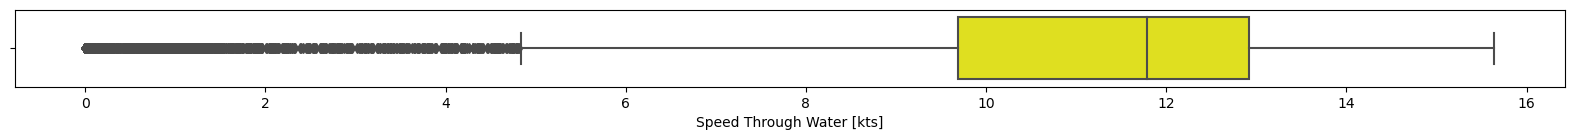

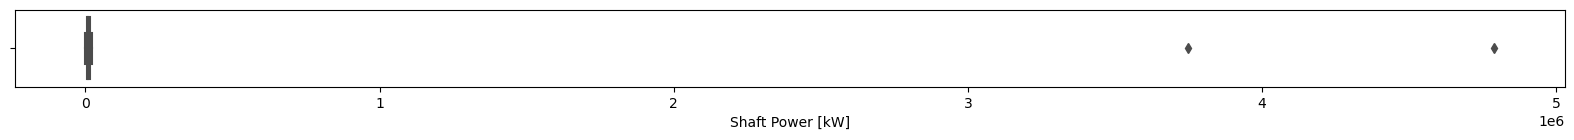

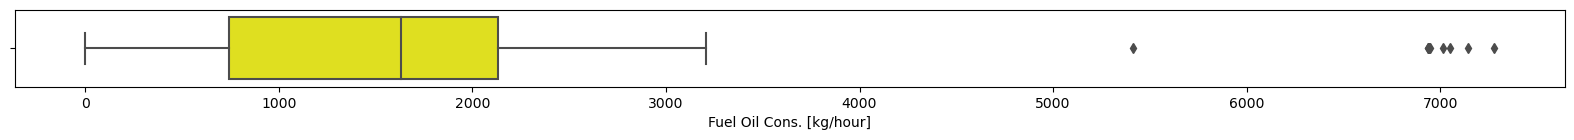

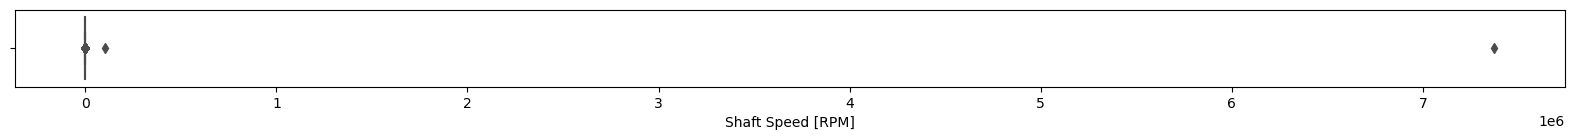

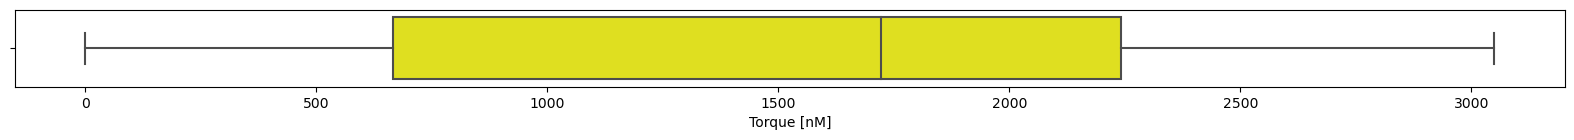

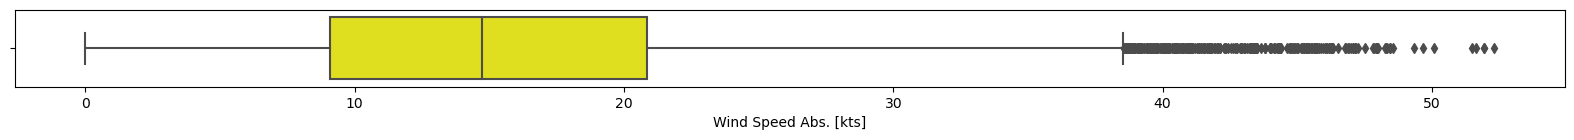

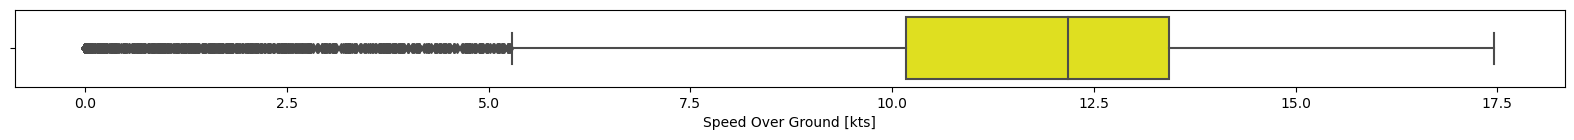

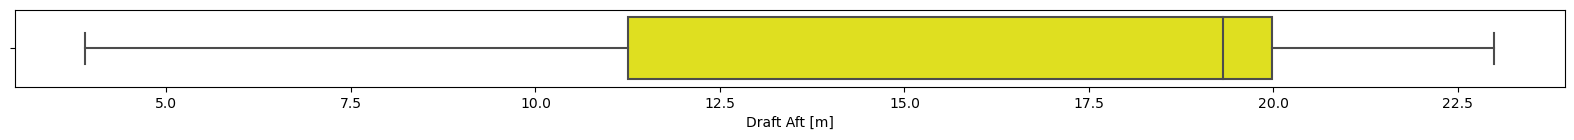

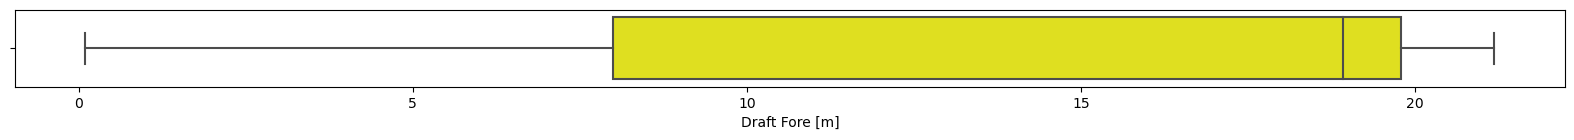

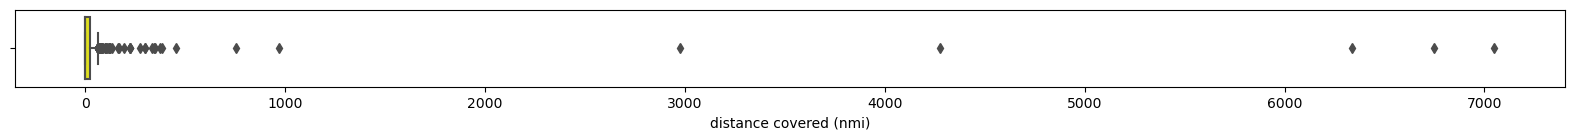

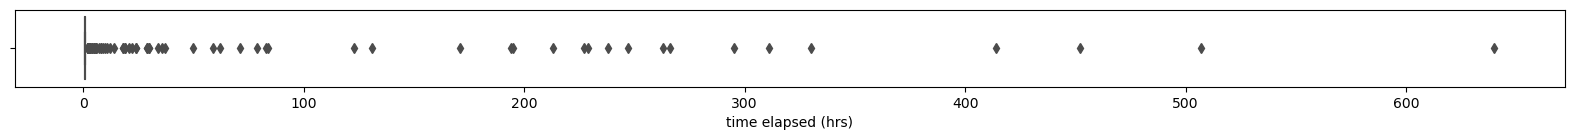

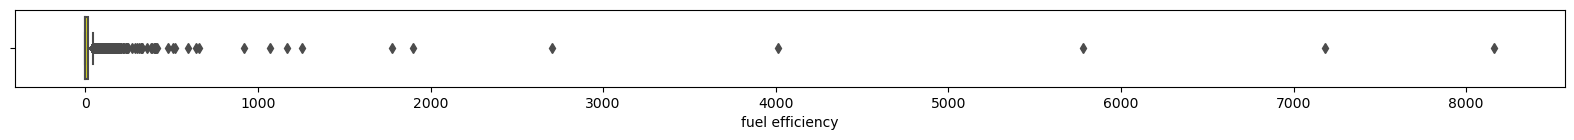

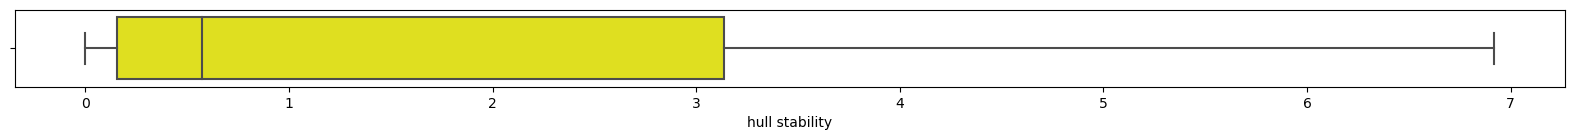

In [19]:
# Plotting box plots for the selected columns to inspect the outliers visually

for i in selected_columns:
    plt.figure(figsize=(20,1))
    sb.boxplot(x= df1[i], color = "yellow")

In [20]:
df2 = df1 # creating a copy

In [21]:
# removing outliers using IQR method

for i in selected_columns:
    
    q1 = df2[i].quantile(0.25)
    q3 = df2[i].quantile(0.75)
    
    iqr = q3-q1
    
    ub = q3 + 1.5*iqr # In every column we find the points beyond the lower bound significant and points beyond the upper bound as outliers
    
    df2 = df2[df2[i]<=ub]

In [22]:
df2[selected_columns].describe()

,Speed Through Water [kts],Shaft Power [kW],Fuel Oil Cons. [kg/hour],Shaft Speed [RPM],Torque [nM],Wind Speed Abs. [kts],Speed Over Ground [kts],Draft Aft [m],Draft Fore [m],distance covered (nmi),time elapsed (hrs),fuel efficiency,hull stability
count,28239.000000,28239.000000,28239.000000,28239.000000,28239.000000,28239.000000,28239.000000,28239.000000,28239.000000,28239.000000,28239.0,28239.000000,28239.000000
mean,11.520624,11810.687614,1728.544305,48.480991,1729.254952,16.064308,11.988592,16.559329,15.184843,12.654999,1.0,7.164032,1.435403
std,2.524019,6199.765927,707.978615,11.087545,712.271728,7.756662,2.643893,4.263517,5.729268,17.886527,0.0,10.415949,1.500168
min,0.000000,0.000000,0.166667,0.000000,0.000000,0.703333,0.000000,7.200000,3.900000,0.000000,1.0,0.000000,0.000000
25%,10.731088,7244.308333,1188.741667,43.001667,1245.933333,10.077500,11.110000,11.281667,8.011667,0.000000,1.0,0.000000,0.146667
50%,12.045000,11038.266667,1832.916667,49.941667,1904.883333,15.485000,12.501667,19.425000,19.040000,0.000000,1.0,0.000000,0.491667
75%,13.087500,14656.658333,2263.108333,54.562500,2294.658333,21.342020,13.586667,19.986667,19.763333,24.887531,1.0,13.465250,3.045000
max,15.643333,24000.000000,3136.083333,63.000000,3048.750000,38.528333,17.465000,22.993333,21.135000,64.501614,1.0,42.347340,5.970000


#### 4. Visualizing the predictor variable

In [23]:
df3 = df2 # creating a copy

Text(0.5, 1.0, 'KDE distribution graph for the KPI: Fuel consumed per hour')

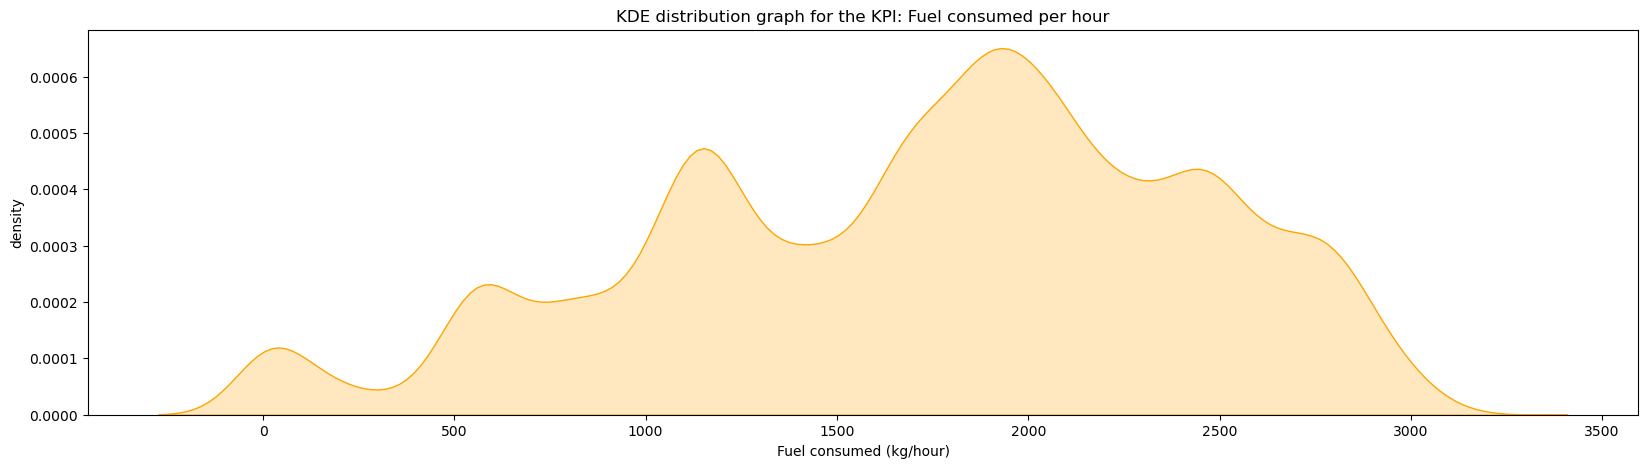

In [24]:
# Plotting the density curve for the KPI : Fuel consumed kg/hr

plt.figure(figsize = (20,5))
sb.kdeplot(data = df3, x= df3["Fuel Oil Cons. [kg/hour]"], color = "orange", fill = True)
plt.xlabel("Fuel consumed (kg/hour)")
plt.ylabel("density")
plt.title("KDE distribution graph for the KPI: Fuel consumed per hour")

#### 5. Analysing the performance of the ship over time

In [25]:
import scipy.stats as sp

In [26]:
df4 = df3 # checkpoint

Here I wish to analyse the performance of ship over the period of time by comparing the significane
of difference in means of Mileage of the ships at each year.

I'm using a ANOVA test for this as there are more than subcategories(in this case years)

Null hypothesis : There's no significance difference in mean value of Mileage between the subgroups.
Alternative hypothesis: There's a significant difference in mean value of Mileage between the subgroups.

In [27]:
# Anova test

ANOVA_result = sp.f_oneway(df4[df4["year"]==2018]["fuel efficiency"],
                           df4[df4["year"]==2019]["fuel efficiency"],
                           df4[df4["year"]==2020]["fuel efficiency"],
                           df4[df4["year"]==2021]["fuel efficiency"],
                           df4[df4["year"]==2022]["fuel efficiency"],
                           df4[df4["year"]==2023]["fuel efficiency"],
                           df4[df4["year"]==2024]["fuel efficiency"])

In [28]:
ANOVA_result

F_onewayResult(statistic=18.946408961282096, pvalue=3.843686374034361e-22)

A close to zero p value rejects the null hypothesis.

Therefore, there's a significant variation in the performance of the ship over the period of time.

#### 6. Exporting

In [29]:
df5 = df4 # checkpoint

In [30]:
# Exporting the transformed dataset

time = datetime.now().strftime("%Y-%m-%d %H.%M.%S") # getting the current time to save the file along with the time of saving
filename ="Transformed data "+ str(time) + ".csv" 
df5.to_csv(filename, index = True)